<a href="https://colab.research.google.com/github/themattinthehatt/Caltech_DATASAI_Neuroscience_23/blob/generative/07_17_23_day6_generative_models/code/diy_notebooks/Caltech_2023_IBL_GLM_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLM-HMM for IBL choice data
This notebook contains code to:
* load choice data for a single subject
* fit a GLM-HMM
* plot GLM-HMM results

# Install libraries

In [8]:
# install glm-hmm core
! pip install git+https://github.com/zashwood/ssm.git

# install IBL libraries
! pip install ONE-api
! pip install ibllib
! pip install psychofit

  Cloning https://github.com/zashwood/ssm.git to c:\users\justin hong\appdata\local\temp\pip-req-build-ukdm9i1o
  Resolved https://github.com/zashwood/ssm.git to commit e9b408b79e2ab22a05ca93c3a1f78a7dae461992
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/zashwood/ssm.git 'C:\Users\Justin Hong\AppData\Local\Temp\pip-req-build-ukdm9i1o'


# Import libraries

In [9]:
from brainbox.io.one import SessionLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psychofit as psy
import seaborn as sns
import ssm

# Configure ONE

In [10]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Downloading: C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\tmpn1rne7qs\cache.zip Bytes: 6254178


100%|██████████| 5.964448928833008/5.964448928833008 [00:01<00:00,  5.27it/s]


# Helper functions

In [11]:
def create_stim_vector(stim_left, stim_right):
    # want stim_right - stim_left
    # Replace NaNs with 0:
    stim_left = np.nan_to_num(stim_left, nan=0)
    stim_right = np.nan_to_num(stim_right, nan=0)
    # now get 1D stim
    signed_contrast = stim_right - stim_left
    return signed_contrast


def create_previous_choice_vector(choice):
    ''' choice: choice vector of size T
        previous_choice : vector of size T with previous choice made by
        animal - output is in {0, 1}, where 0 corresponds to a previous left
        choice; 1 corresponds to right.
        If the previous choice was a violation, replace this with the choice
        on the previous trial that was not a violation.
        locs_mapping: array of size (~num_viols)x2, where the entry in
        column 1 is the location in the previous choice vector that was a
        remapping due to a violation and the
        entry in column 2 is the location in the previous choice vector that
        this location was remapped to
    '''
    previous_choice = np.hstack([np.array(choice[0]), choice])[:-1]
    locs_to_update = np.where(previous_choice == -1)[0]
    locs_with_choice = np.where(previous_choice != -1)[0]
    loc_first_choice = locs_with_choice[0]
    locs_mapping = np.zeros((len(locs_to_update) - loc_first_choice, 2),
                            dtype='int')

    for i, loc in enumerate(locs_to_update):
        if loc < loc_first_choice:
            # since no previous choice, bernoulli sample: (not output of
            # bernoulli rvs is in {1, 2})
            previous_choice[loc] = bernoulli.rvs(0.5, 1) - 1
        else:
            # find nearest loc that has a previous choice value that is not
            # -1, and that is earlier than current trial
            potential_matches = locs_with_choice[
                np.where(locs_with_choice < loc)]
            absolute_val_diffs = np.abs(loc - potential_matches)
            absolute_val_diffs_ind = absolute_val_diffs.argmin()
            nearest_loc = potential_matches[absolute_val_diffs_ind]
            locs_mapping[i - loc_first_choice, 0] = int(loc)
            locs_mapping[i - loc_first_choice, 1] = int(nearest_loc)
            previous_choice[loc] = previous_choice[nearest_loc]
    assert len(np.unique(
        previous_choice)) <= 2, "previous choice should be in {0, 1}; " + str(
        np.unique(previous_choice))
    return previous_choice, locs_mapping


def create_wsls_covariate(previous_choice, success, locs_mapping):
    '''
    inputs:
    success: vector of size T, entries are in {-1, 1} and 0 corresponds to
    failure, 1 corresponds to success
    previous_choice: vector of size T, entries are in {0, 1} and 0
    corresponds to left choice, 1 corresponds to right choice
    locs_mapping: location remapping dictionary due to violations
    output:
    wsls: vector of size T, entries are in {-1, 1}.  1 corresponds to
    previous choice = right and success OR previous choice = left and
    failure; -1 corresponds to
    previous choice = left and success OR previous choice = right and failure
    '''
    # remap previous choice vals to {-1, 1}
    remapped_previous_choice = 2 * previous_choice - 1
    previous_reward = np.hstack([np.array(success[0]), success])[:-1]
    # Now need to go through and update previous reward to correspond to
    # same trial as previous choice:
    for i, loc in enumerate(locs_mapping[:, 0]):
        nearest_loc = locs_mapping[i, 1]
        previous_reward[loc] = previous_reward[nearest_loc]
    wsls = previous_reward * remapped_previous_choice
    assert len(np.unique(wsls)) == 2, "wsls should be in {-1, 1}"
    return wsls


def remap_choice_vals(choice):
    # raw choice vector has CW = 1 (correct response for stim on left),
    # CCW = -1 (correct response for stim on right) and viol = 0.  Let's
    # remap so that CW = 0, CCw = 1, and viol = -1
    choice_mapping = {1: 0, -1: 1, 0: -1}
    new_choice_vector = [choice_mapping[old_choice] for old_choice in choice]
    return new_choice_vector


def create_design_mat(choice, stim_left, stim_right, rewarded):
    # Create unnormalized_inpt: with first column = stim_right - stim_left,
    # second column as past choice, third column as WSLS
    stim = create_stim_vector(stim_left, stim_right)
    T = len(stim)
    design_mat = np.zeros((T, 4))
    design_mat[:, 0] = stim
    # bias
    design_mat[:, 1] = 1
    # make choice vector so that correct response for stim>0 is choice =1
    # and is 0 for stim <0 (viol is mapped to -1)
    choice = remap_choice_vals(choice)
    # create past choice vector:
    previous_choice, locs_mapping = create_previous_choice_vector(choice)
    # create wsls vector:
    wsls = create_wsls_covariate(previous_choice, rewarded, locs_mapping)
    # map previous choice to {-1,1}
    design_mat[:, 2] = 2 * previous_choice - 1
    design_mat[:, 3] = wsls
    return design_mat

# Load and format data

In [12]:
sess = one.search(subject='KS014')
# sess = one.search(subject='DY_014')

print(f'{len(sess)} total sessions')

trials_list = []
for eid in sess:  # start with most recent sessions
    print(f'Collecting data for {eid}')
    # build session loader
    sess_loader = SessionLoader(one=one, eid=eid)
    # load trials dataframe
    try:
        sess_loader.load_trials()
    except BaseException:
        print('Error loading trials')
        continue
    trials = sess_loader.trials
    # only fit to trials in biased blocks
    trials_to_study = trials.probabilityLeft != 1.5
    # only use sessions with lots of trials
    if np.sum(trials_to_study) < 200:
      print(f'Session has too few trials ({np.sum(trials_to_study)})')
      continue
    # animal must make a choice on most trials
    n_trials_no_resp = len(np.where(trials.choice[trials_to_study] == 0)[0])
    if n_trials_no_resp >= 10:  # != 0:
        print(f'Session has too many no-response trials ({n_trials_no_resp})')
        continue
    trials_list.append(trials[trials_to_study])

print(f'Found {len(trials_list)} sessions')

9 total sessions


C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\_ibl_trials.stimOff_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 30.8kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\_ibl_trials.table.pqt: 100%|██████████| 53.7k/53.7k [00:00<00:00, 216kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-07\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 24.5kB/s]


C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-05\001\alf\_ibl_trials.stimOff_times.npy: 100%|██████████| 5.63k/5.63k [00:00<00:00, 29.8kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-05\001\alf\_ibl_trials.table.pqt: 100%|██████████| 55.8k/55.8k [00:00<00:00, 227kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-05\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.63k/5.63k [00:00<00:00, 27.6kB/s]


C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-03\001\alf\_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 14.8kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-03\001\alf\_ibl_trials.table.pqt: 100%|██████████| 45.4k/45.4k [00:00<00:00, 160kB/s]
C:\Users\Justin Hong\Downloads\ONE\openalyx.internationalbrainlab.org\cortexlab\Subjects\KS014\2019-12-03\001\alf\_ibl_trials.stimOff_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 19.2kB/s]

Error loading trials
Error loading trials
Error loading trials
Error loading trials
Error loading trials
Error loading trials
Found 3 sessions


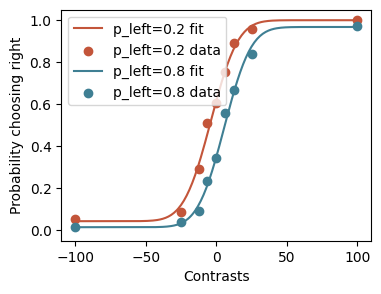

In [13]:
# let's look at the psychometric curve of the animal for the unbiased block
from brainbox.behavior.training import get_signed_contrast, compute_performance, compute_psychometric

trials_concat = pd.concat(trials_list)

signed_contrast = get_signed_contrast(trials_concat)
contrasts_fit = np.arange(-100, 100)

prob_right_20, contrasts_20, _ = compute_performance(trials_concat, signed_contrast=signed_contrast, block=0.2, prob_right=True)
out_20 = compute_psychometric(trials_concat, signed_contrast=signed_contrast, block=0.2, plotting=True, compute_ci=False, alpha=0.32)
prob_right_fit_20 = psy.erf_psycho_2gammas(out_20, contrasts_fit)

prob_right_80, contrasts_80, _ = compute_performance(trials_concat, signed_contrast=signed_contrast, block=0.8, prob_right=True)
out_80 = compute_psychometric(trials_concat, signed_contrast=signed_contrast, block=0.8, plotting=True, compute_ci=False, alpha=0.32)
prob_right_fit_80 = psy.erf_psycho_2gammas(out_80, contrasts_fit)

cmap = sns.diverging_palette(20, 220, n=3, center="dark")

fig, ax = plt.subplots(figsize=(4, 3))
fit_20 = ax.plot(contrasts_fit, prob_right_fit_20, color=cmap[0])
data_20 = ax.scatter(contrasts_20, prob_right_20, color=cmap[0])
fit_80 = ax.plot(contrasts_fit, prob_right_fit_80, color=cmap[2])
data_80 = ax.scatter(contrasts_80, prob_right_80, color=cmap[2])

ax.legend(
    [fit_20[0], data_20, fit_80[0], data_80],
    ['p_left=0.2 fit', 'p_left=0.2 data', 'p_left=0.8 fit', 'p_left=0.8 data'],
    loc='upper left'
)
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('Probability choosing right')
ax.set_xlabel('Contrasts')
plt.show()

In [14]:
# create model inputs/outputs as a list of arrays

Xs = []
ys = []
masks = []
for trials in trials_list:

    # create input to GLM-HMM - array of shape (T, 3)
    stim_left = trials.contrastLeft.to_numpy()
    stim_right = trials.contrastRight.to_numpy()
    choices = trials.choice.to_numpy()
    rewards = trials.feedbackType.to_numpy()

    X = create_design_mat(stim_left=stim_left, stim_right=stim_right, choice=choices, rewarded=rewards)
    Xs.append(X)

    # create target variable of GLM-HMM - array of shape (T, 1)
    choices_remapped = remap_choice_vals(choices)
    y = np.array(choices_remapped)[:, None]  # shape (T,) -> (T, 1)
    ys.append(y)

    # create masks for trials where animal does not respond
    mask = np.ones(y.shape, dtype=bool)
    mask[y==-1] = 0
    masks.append(mask)

    # update choices so ssm doesn't complain about invalid values
    ys[-1][mask==0] = 0

# z-score cols (but not bias)
s = np.std(np.concatenate(Xs), axis=0)
s[1] = 1
Xs = [x / s for x in Xs]

# Fit the GLM-HMM
* First, fit a standard GLM
* Use GLM parameters to initialize GLM-HMM
* Fit the GLM-HMM

In the original Ashwood paper, they took an additional step to better regularize the model:
* Fit a standard GLM to ALL sessions
* Use the global GLM to initialize a global GLM-HMM, fit global GLM-HMM to ALL sessions
* Use the global GLM-HMM to initialize subject-specific GLM-HMMs

In [15]:
# set the parameters of the GLM/GLM-HMM
num_states = 3          # number of discrete states
obs_dim = 1             # number of observed dimensions
num_categories = 2      # number of categories for output
input_dim = Xs[0].shape[1]  # input dimensions
prior_sigma = 100       # prior on GLM weights is N(prior_mean, prior_sigma * I)
alpha = 1               # transition prior is pi_k ~ Dir(alpha + kappa * e_k)
kappa = 0               # transition prior is pi_k ~ Dir(alpha + kappa * e_k)

# first, we make a GLM that we will use to initialize the GLM-HMM
np.random.seed(0)
glm = ssm.HMM(
    1,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
    transitions="sticky",
    transitions_kwargs=dict(alpha=alpha, kappa=kappa),
)
ll_glm = glm.fit(ys, inputs=Xs, masks=masks, method="em", num_iters=200, tolerance=10**-4)

Converged to LP: -685.5:   0%|          | 1/200 [00:01<04:03,  1.23s/it]


In [16]:
# set random seed for reproducible results
np.random.seed(0)

# make a GLM-HMM
glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
    transitions="sticky",
    transitions_kwargs=dict(alpha=alpha, kappa=kappa),
)

# initialize the transition matrix with something close to identity
t = 0.95 * np.eye(num_states) + np.abs(0.05 * np.random.randn(num_states, num_states))
t /= np.sum(t, axis=1)
glmhmm.transitions.params = (np.log(t),)

# initialize the weights with perturbed GLM weights
init_weights = np.tile(glm.observations.params, (num_states, 1, 1))
init_weights += np.random.randn(*init_weights.shape)
glmhmm.observations.params = init_weights

# maximum number of EM iterations; fitting will stop earlier if increase in LL is below tolerance specified by tolerance parameter
ll = glmhmm.fit(ys, inputs=Xs, masks=masks, method="em", num_iters=200, initialize=False, tolerance=10**-4)

Converged to LP: -669.8:  19%|█▉        | 38/200 [00:06<00:28,  5.70it/s]


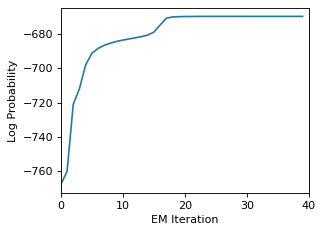

In [17]:
# plot the log probabilities of the model through training
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ll, label="EM")
plt.xlabel("EM Iteration")
plt.xlim(0, len(ll))
plt.ylabel("Log Probability")
plt.show()

# Plot results

### Weights for each state

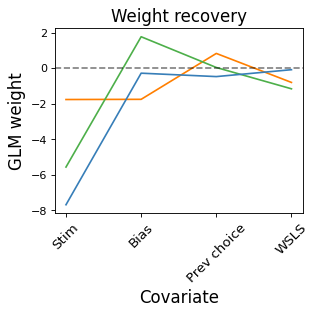

In [18]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k], lw=1.5, linestyle = '-')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
plt.xticks([0, 1, 2, 3], ['Stim', 'Bias', 'Prev choice', 'WSLS'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("Weight recovery", fontsize=15)
plt.show()

### Transition matrix

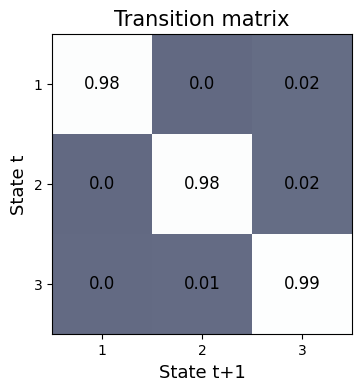

In [19]:
plt.figure(figsize=(3, 3))
recovered_trans_mat = np.exp(glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center", color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.xlabel('State t+1', fontsize=13)
plt.ylabel('State t', fontsize=13)
plt.title("Transition matrix", fontsize=15)
plt.subplots_adjust(0, 0, 1, 1)

### Posterior state probabilities

In [20]:
# get expected states
idx = 0
posterior_probs = glmhmm.expected_states(data=ys[idx], input=Xs[idx], mask=masks[idx])[0]

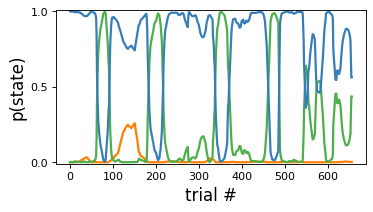

In [21]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(posterior_probs[:, k], label="State " + str(k + 1), lw=2, color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.show()

### Occupancy rate

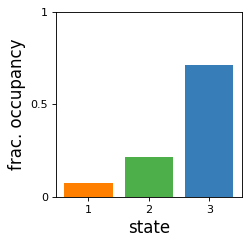

In [22]:
posterior_probs = np.concatenate([glmhmm.expected_states(data=y, input=x)[0] for y, x in zip(ys, Xs)])

# get state with maximum posterior probability for each trial
state_max_posterior = np.argmax(posterior_probs, axis=1)
# now obtain state fractional occupancies
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies / np.sum(state_occupancies)

fig = plt.figure(figsize=(3, 3), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width=0.8, color=cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize=10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize=15)
plt.ylabel('frac. occupancy', fontsize=15)
plt.show()

### Psychometric curves as a function of state

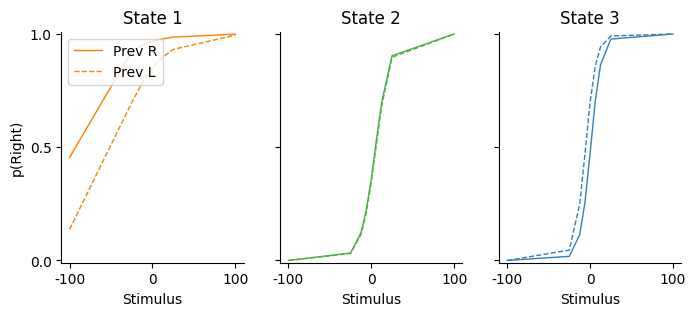

In [23]:
stim_vals = np.concatenate([x[:, 0] for x in Xs])
stim_vals_vec = np.unique(stim_vals)
stim_vals_vec = stim_vals_vec[:, None]
X_tmp_prevR = np.hstack([stim_vals_vec, np.ones_like(stim_vals_vec), -1 * np.ones_like(stim_vals_vec), np.ones_like(stim_vals_vec)])
X_tmp_prevL = np.hstack([stim_vals_vec, np.ones_like(stim_vals_vec), np.ones_like(stim_vals_vec), np.ones_like(stim_vals_vec)])
yhats_prevR = np.exp(glmhmm.observations.calculate_logits(X_tmp_prevR))
yhats_prevL = np.exp(glmhmm.observations.calculate_logits(X_tmp_prevL))

plt.figure(figsize=(8, 3))
for k in range(num_states):
    plt.subplot(1, num_states, k+1)
    plt.plot(stim_vals_vec, yhats_prevR[:, k, 1], '-', color=cols[k], alpha=1, lw=1, label='Prev R')
    plt.plot(stim_vals_vec, yhats_prevL[:, k, 1], '--', color=cols[k], alpha=1, lw=1, label='Prev L')
    plt.xticks([stim_vals_vec[0, 0], 0, stim_vals_vec[-1, 0]], [-100, 0, 100], fontsize=10)
    plt.xlabel('Stimulus')
    if k == 0:
        plt.yticks([0, 0.5, 1], fontsize=10)
        plt.ylabel('p(Right)')
        plt.legend(loc='upper left')
    else:
        plt.yticks([0, 0.5, 1], ['', '', ''], fontsize=10)
        plt.ylabel('')
    plt.title(f'State {k+1}')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylim((-0.01, 1.01))

# Exercises
* how do results change with a different number of discrete states?
* how do results change with a different set of predictors (e.g. remove win-stay-lose-switch)
* plot HMM discrete states on top of block information (trials.probabilityLeft)
